# Linear Regression of Baseball Data based on the Movie "Moneyball"

In the movie "Moneyball", Dr. Paul DePodesta, the Oakland A's team statistician claim that in order to get to the playoffs, you must win at least 95 games and have at least 135 more runs than your opponents.

He also contends that on-base percentage is very important in affecting runs scored, followed by slugging percentage, and he also contends that batting average is over-valued.  This notebook will attempt to support or disprove his theories.

This notebook is part of the MIT course "The Analytics Edge" where the solution was originally done in R.  In this notebook, we will see if we can verify Dr. DePodesta's claims.

**NOTE:** Slight discrepancy found between the book and video course.  The book uses data from years 1996 through 2001.  However, in the video course, it includes years earlier than 1996.  This unfortunately can cause confusion!

In [1]:
from IPython.display import Image  # Embed binary of images so that image file does not need to be provided

### Summary of Oakland A's Dr. DePodesta's goal for the team:

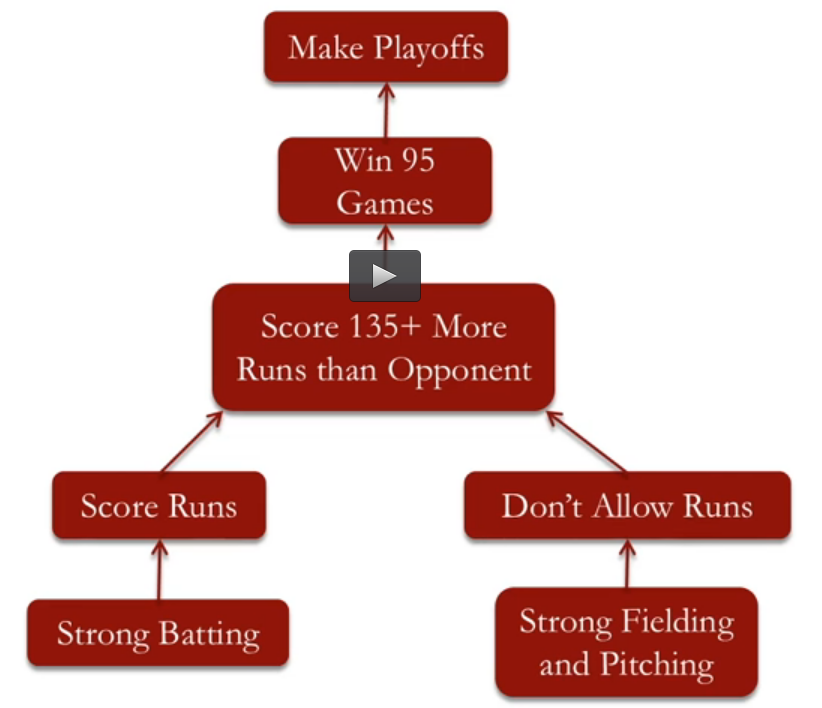

In [2]:
Image("../images/baseball_team_goal.png")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf  # Using formula API

In [4]:
baseball = pd.read_csv('../data/baseball.csv')

In [5]:
baseball.shape

(1232, 15)

In [6]:
baseball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


Data metadata:

- Team: team's 3-letter acronym
- League: NL = National League, AL=American League
- Year: season year
- RS: runs scored
- RA: runs allowed
- W: number of games won
- OBP: on-base percentage (percentage of time player ends up on base, including walks)
- SLG: slugging percentage (how far player gets around the baseson his turn, measuring power)
- BA: batting average
- Playoffs: whether or not the team reached the playoffs (0=No, 1=Yes)
- RankSeason: Team rank during the regular season
- RankPlayoffs: Team rank during the playoffs
- G: Number of games played in regular season
- OOBP: opponent's on-base percentage
- OSLG: opponent's slugging percentage

#### In the movie, the data set that Dr. DePodesta was working with was only for the years 1996 through 2001

In [7]:
moneyball = baseball.query("Year < 2002")

In [8]:
moneyball.shape

(902, 15)

In [9]:
moneyball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
330,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384
333,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439
334,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393


### Dr. DePodesta claimed that the team must have at least 95 games to be able to reach the playoffs.  Can we confirm?

We will use seaborn's stripplot plot to plot the number of wins for each team and the color of the plots will denote if they reached the playoffs (1) or not (0).  We also only want years greater than 1995 to match the output in the video.

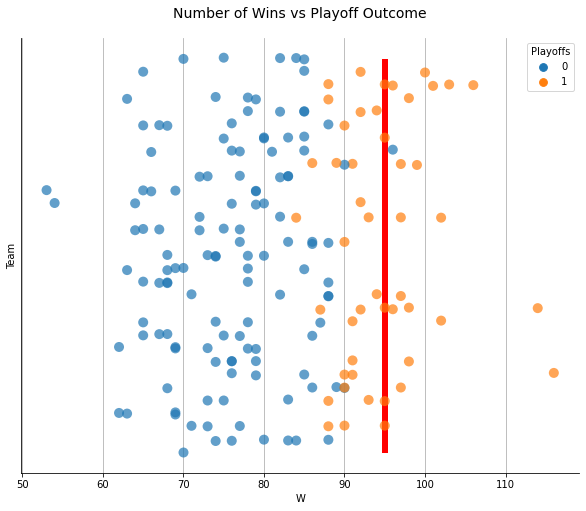

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
(sns.stripplot(x="W",
             y="Team",
             hue="Playoffs",
             data=moneyball.query("Year > 1995"),  # For some reason they used year > 1995 in video
             alpha=0.7,
             s=10,
             ax=ax
            )
).set_yticks([]);  # Remove the y-ticks and labels to match what was shown in video course
plt.title("Number of Wins vs Playoff Outcome", pad=20, fontsize=14)
plt.grid(True)
sns.despine()
plt.vlines(x=95, ymin=0, ymax=30, colors='red', linewidth=6);

### Answer: approximately 95 wins

### Dr. DePodesta also claimed that the team must score 134 more runs than their opponents.  Can we confirm?

We need to create a new column called "RD" to represent run difference or runs scored (RS) minus runs allowed (RA): 

In [11]:
moneyball = moneyball.assign(RD=moneyball['RS'] - moneyball['RA'])

In [12]:
moneyball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
330,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
333,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142
334,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27


#### Let's create a scatter plot of wins (W) versus runs difference (RD):

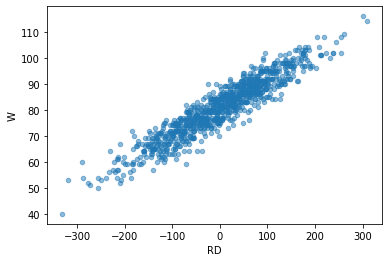

In [13]:
moneyball.plot.scatter(x='RD', y='W', alpha=0.5);

From the chart above, we see there is a positive correlation between wins and runs difference.

#### Let's create a linear regression model where the dependent variable is the wins column (W) and independent variable is the runs difference (RD):

In [14]:
model = smf.ols('W ~ RD', data=moneyball).fit()

In [15]:
predictions = model.predict()

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     6651.
Date:                Sat, 13 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:41:12   Log-Likelihood:                -2515.5
No. Observations:                 902   AIC:                             5035.
Df Residuals:                     900   BIC:                             5045.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     80.8814      0.131    616.675      0.000      80.624      81.139
RD             0.1058      0.001     81.554      0.000       0.103       0.108
==============================================================================
Omnibus:                        5.788   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.736
Skew:                          -0.195   Prob(JB):                       0.0568
Kurtosis:                       3.033   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### So our linear equation becomes:

$W = 0.1058 \bullet (RS-RA) + 80.8814$<br>
or<br>
$W = 0.1058 \bullet RD + 80.8814$

#### Let's plot the actual data with the model or prediction line:

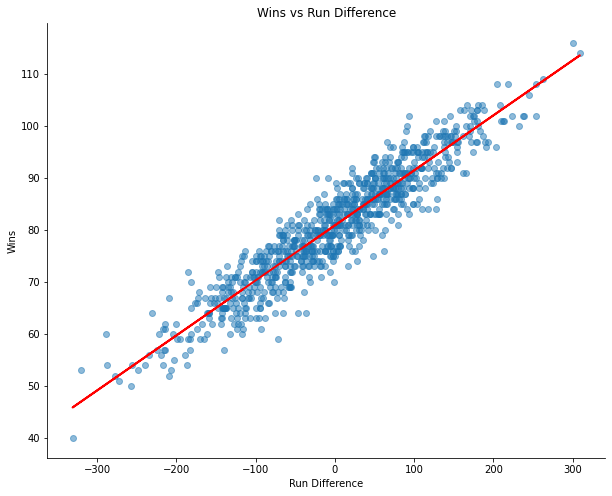

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(moneyball['RD'], moneyball['W'], 'o', alpha=0.5)
plt.plot(moneyball['RD'], predictions, 'r', linewidth=2)
plt.xlabel('Run Difference')
plt.ylabel('Wins')
plt.title('Wins vs Run Difference')
sns.despine()
plt.show()

**Proof:** What is minimum run difference needed to have more than 95 games won?

From our model metrics output above, the y-intercept is 80.8814 and the slope is 0.1058.

$y = mx + b$<br><br>
$W = 0.1058 \bullet RD + 80.8814$<br><br>
$W \geq 95$<br><br>

Now we need to solve for ```RD```:

$0.1058 \bullet RD  + 80.8814 \geq 95$<br><br>
$RD \geq \frac{95 - 80.8814}{0.1058} = 133$<br><br>
$RD \geq 133$

**Answer:** You need to have a run difference of at least 133 runs

### How to Predict Runs

To predict the number of runs, we need to ask ourselves what factors affects runs?  Dr. DePodesta claimed that the following are important factors:

- On-base percentage
- Slugging percentage

He also claimed that batting average was over-valued.

**Proof:**
- On-Base Percentage is most important
- Slugging Percentage is next important
- Batting Average is overvalued

Can we use linear regression to verify which baseball stats are important for predicting runs?

#### Let's view our data again

In [18]:
moneyball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
330,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
333,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142
334,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27


So we want to create a linear regression where the dependent variable is runs scored (RS) and the dependent variables are on-base percentage(OBP), slugging percentage (SLG), and batting average (BA):

In [19]:
RunsReg = smf.ols('RS ~ OBP+SLG+BA', data=moneyball).fit()

In [20]:
RunsReg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3989.
Date:                Sat, 13 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:41:13   Log-Likelihood:                -4170.2
No. Observations:                 902   AIC:                             8348.
Df Residuals:                     898   BIC:                             8368.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -788.4570     19.697    -40.029      0.000    -827.115    -749.799
OBP         2917.4214    110.466     26.410      0.000    2700.619    3134.224
SLG         1637.9277     45.994     35.612      0.000    1547.659    1728.197
BA          -368.9661    130.580     -2.826      0.005    -625.244    -112.688
==============================================================================
Omnibus:                        3.441   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.381
Skew:                           0.150   Prob(JB):                        0.184
Kurtosis:                       3.018   Cond. No.                         214.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hmmm, we have a negative coefficient for batting average?  Which is counter-intuative.  It means that when a team has a higher batting average, it will tend to have lower runs scored.  The cause for this is the existence of multicollinearity.

In [21]:
corr = moneyball.corr()

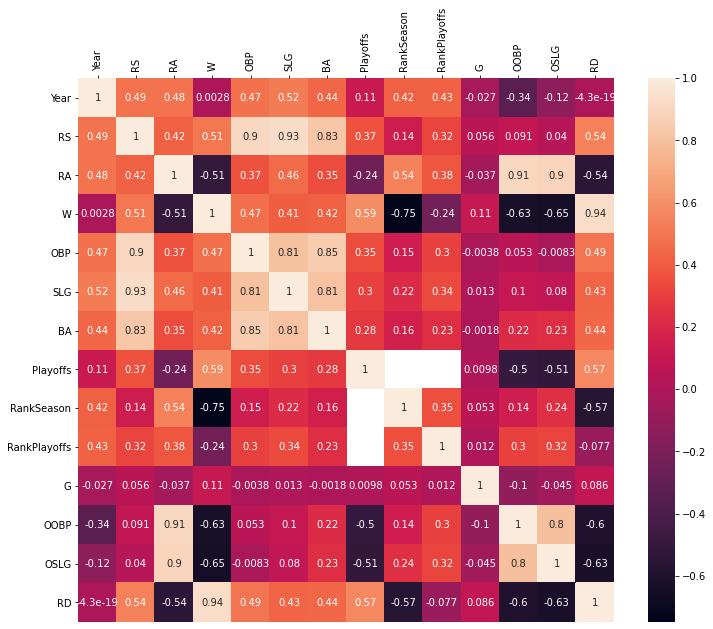

In [22]:
fig, ax = plt.subplots(figsize=(12,10))
ax.xaxis.set_ticks_position('top')
sns.heatmap(corr, annot=True, ax=ax);

We see from the correlation heatmap above that the independent variables OBP, SLG, and BA are very correlated with each other with correlation coefficients of at least 0.8.

Since BA has lesser significance (from the lower t value), we will remove it first and see if there is a major change to the linear regression model's accuracy (R-squared).

In [23]:
RunsRegWithOutBA = smf.ols('RS ~ OBP+SLG', data=moneyball).fit()

In [24]:
RunsRegWithOutBA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RS   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     5934.
Date:                Sat, 13 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:41:15   Log-Likelihood:                -4174.2
No. Observations:                 902   AIC:                             8354.
Df Residuals:                     899   BIC:                             8369.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -804.6271     18.921    -42.526      0.000    -841.761    -767.493
OBP         2737.7680     90.685     30.190      0.000    2559.790    2915.746
SLG         1584.9086     42.156     37.597      0.000    1502.174    1667.643
==============================================================================
Omnibus:                        3.099   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.212   Jarque-Bera (JB):                3.106
Skew:                           0.143   Prob(JB):                        0.212
Kurtosis:                       2.972   Cond. No.                         134.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With BA removed, R2 remain the same.

#### For added thoroughness, let's also remove slugging percentage (SLG) and then evaluate the model's performance

In [25]:
RunsRegWithoutSLG_BA = smf.ols('RS ~ OBP', data=moneyball).fit()

In [26]:
RunsRegWithoutSLG_BA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RS   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     4069.
Date:                Sat, 13 Jun 2020   Prob (F-statistic):               0.00
Time:                        15:41:15   Log-Likelihood:                -4600.3
No. Observations:                 902   AIC:                             9205.
Df Residuals:                     900   BIC:                             9214.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1079.0244     27.982    -38.562      0.000   -1133.942   -1024.107
OBP         5486.2973     86.012     63.785      0.000    5317.490    5655.105
==============================================================================
Omnibus:                        1.283   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.357
Skew:                          -0.085   Prob(JB):                        0.508
Kurtosis:                       2.914   Cond. No.                         71.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our model with SLG also removed performed worse with a lower R2 value (0.85)

#### How do we determine if OBP has more impact to the dependent variable than SLG?

We can calculate what are known as "standardized coefficients" if you create a linear regression model from standardized values of our data set, instead of their original values.

One way we can normalize our data set's values to the standard normal is by using scipy's stats.zscore() [method](https://stackoverflow.com/questions/50842397/how-to-get-standardised-beta-coefficients-for-multiple-linear-regression-using) or if you already have limited your dataframe to consist of only numeric columns, we can just subtract the dataframe by the mean, then divide by the standard deviation as in this SO [example](https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame).  The calculations are performed on a column-wise basis, not based on the entire dataframe.

In [27]:
# standardizing dataframe
# moneyball_z = moneyball.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)

In [28]:
# moneyball_z.head()

#### Normalizing using pandas method:

In [29]:
moneyball_subset = moneyball.query("Year > 1995")[['RS','OBP','SLG','BA']]

In [30]:
normalized_df=(moneyball_subset-moneyball_subset.mean())/moneyball_subset.std()

In [31]:
normalized_df.head()

,RS,OBP,SLG,BA
330,-1.262268,-0.836504,-0.814595,-0.597946
331,0.224490,0.151581,0.543828,-0.083751
332,-0.817411,-1.048237,-0.557596,-0.683645
333,-1.309095,-1.401125,-1.732449,-1.712033
334,-0.314020,-0.342462,0.433686,-0.169450


In [32]:
model = smf.ols('RS ~ OBP+SLG', data=normalized_df).fit()

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RS   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     959.7
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           2.26e-94
Time:                        15:41:16   Log-Likelihood:                -29.867
No. Observations:                 176   AIC:                             65.73
Df Residuals:                     173   BIC:                             75.24
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.18e-16      0.022   5.41e-15      1.000      -0.043       0.043
OBP            0.5821      0.035     16.582      0.000       0.513       0.651
SLG            0.4311      0.035     12.281      0.000       0.362       0.500
==============================================================================
Omnibus:                        1.420   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.492   Jarque-Bera (JB):                1.351
Skew:                           0.213   Prob(JB):                        0.509
Kurtosis:                       2.949   Cond. No.                         2.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### So the final chosen model to predict runs scored is:

$RS = -804.63 + 2737.77 \bullet OBP + 1585.91 \bullet SLG$

### Next, we need to create a model for runs allowed

In [34]:
moneyball.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
330,ANA,AL,2001,691,730,75,0.327,0.405,0.261,0,NaN,NaN,162,0.331,0.412,-39
331,ARI,NL,2001,818,677,92,0.341,0.442,0.267,1,5.0,1.0,162,0.311,0.404,141
332,ATL,NL,2001,729,643,88,0.324,0.412,0.260,1,7.0,3.0,162,0.314,0.384,86
333,BAL,AL,2001,687,829,63,0.319,0.380,0.248,0,NaN,NaN,162,0.337,0.439,-142
334,BOS,AL,2001,772,745,82,0.334,0.439,0.266,0,NaN,NaN,161,0.329,0.393,27


#### Let's see which variables seem to impact runs allowed (RA):

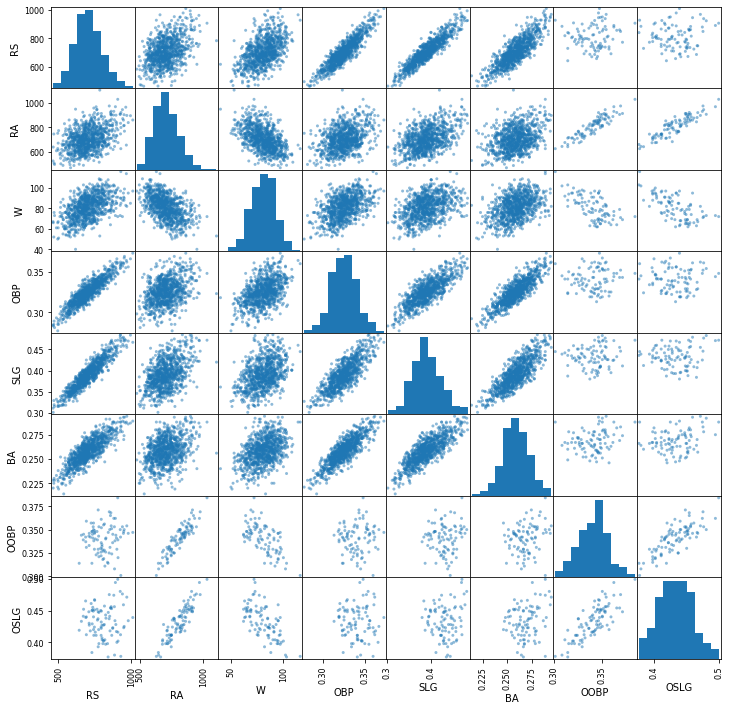

In [35]:
pd.plotting.scatter_matrix(moneyball[['RS', 'RA', 'W', 'OBP', 'SLG', 'BA', 'OOBP', 'OSLG']], figsize=(12, 12));

From above, looking at the 2nd column from the left, we see that OOBP and OSLG have a strong correlation with RA.

So we'll make a linear regression where RA is the dependent variable and OOBP and OSLG are the independent variables

In [36]:
RA_model = smf.ols(formula='RA ~ OOBP + OSLG', data=moneyball).fit()

In [37]:
RA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RA   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     425.8
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           1.16e-45
Time:                        15:41:20   Log-Likelihood:                -418.27
No. Observations:                  90   AIC:                             842.5
Df Residuals:                      87   BIC:                             850.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -837.3779     60.255    -13.897      0.000    -957.142    -717.614
OOBP        2913.5995    291.971      9.979      0.000    2333.276    3493.923
OSLG        1514.2860    175.428      8.632      0.000    1165.604    1862.968
==============================================================================
Omnibus:                        3.836   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                3.104
Skew:                          -0.392   Prob(JB):                        0.212
Kurtosis:                       3.461   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So our model for predicting runs allowed is

$RA = -837.38 + 2913.60 \bullet OOBP + 1514.29 \bullet OSLG$

### We now have models for the runs scored and runs allowed:

#### Runs Scored:

$RS = -804.63 + 2737.77 \bullet OBP + 1585.91 \bullet SLG$

#### Runs Allowed:

$RA = -837.38 + 2913.60 \bullet OOBP + 1514.29 \bullet OSLG$

### Making RS and RA 2002 Predictions Using 2001 Team Statistics

Oakland As 2001 team statistics:

In [38]:
moneyball.query("Team=='OAK' and Year==2001")

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG,RD
350,OAK,AL,2001,884,645,102,0.345,0.439,0.264,1,2.0,4.0,162,0.308,0.38,239


**NOTE:** For unknown reason, 2001 statistics that the video course used was slightly off (0.339 for OBP, 0.430 for SLG).

Using 2001's team statistics:

$RS = -804.63 + 2737.77 \bullet (0.345) + 1585.91 \bullet (0.439)$

$RS = 836$

We predict that for 2002 season, they will have **836** runs scored.

$RA = -837.38 + 2913.60 \bullet (0.308) + 1514.29 \bullet (0.38)$

$RA = 635$

and **635** runs allowed

### Now we can predict the number of wins with our model we made earlier predicting the number of wins using run difference or runs scored minus runs allowed (RS - RA)

Recall below are model for predicting number of wins:

$W = 0.1058 \bullet (RS-RA) + 80.8814$<br>
or<br>
$W = 0.1058 \bullet RD + 80.8814$

$W = 0.1058 \bullet (836 - 635) + 80.8814$

$W = 102$

So for 2002 season, we predict the As will have 102 games won.